# Constitution du corpus et Nettoyage

In [104]:
def nettoyage(texte):
    texte = re.sub(r'(https?:\/\/\S+)|(www\.\S+)', '', texte)
    texte = re.sub(r"[&%!?\|\"{\(\[|_\)\]},\.;/§»«”“‘…–—−]", "", texte)
    texte = re.sub(r"\d", "", texte)
    texte = texte.replace("’", "'")
    texte = texte.replace("'", "' ")
    texte = texte.lower()
    
    # enlever les stopwords
    with open("mots_vides.txt", "r", encoding="utf-8") as f:
        stop_words = set(f.read().splitlines())
    mots = texte.split()
    mots = [mot for mot in mots if mot not in stop_words]
    texte = " ".join(mots)
    
    return texte

In [105]:
import os
from pathlib import Path

corpus_dir = "corpus_seisme"

corpus = []

for category in os.listdir(corpus_dir):
    category_dir = os.path.join(corpus_dir, category)
    for file_path in Path(category_dir).glob("*.txt"):
        with open(file_path, "r", encoding="utf-8") as f:
            text = f.read()
            #prétraitement de chaque texte et sauvagarder dans la liste corpus avec son étiquette
            processed_text = nettoyage(text)
            corpus.append((processed_text, category))
corpus

[('seisme turquie quelques images prises notre équipe témoigne ampleur du désastre du séisme ayant touché turquie faisant plus morts équipe décrit ville fantôme lourdement détruite faisant naître décore apocalyptique sur ville #hameb @chrysler @dranesbelkhiri @fetihvakfiorg effectuer vos dons rdv dans bio @collectifhameb',
  'aide'),
 ("suite au séisme turquie syrie ong sos chrétiens d' orient lance appel aux dons aider familles syriennes victimes du séisme subissent sanctions internationales soutenez ces populations dans désolation url:",
  'aide'),
 ("mission séisme turquie - syrie jour nous sommes au contact population turque dans région d' hatay ville samandag nous avons donner au peuple tous dons collectés couvertures tentes hygiène nourriture médical été livré au poste médical avancé samandag quelques répliques sont présentes légères chance celle eu lieu juste avant notre arrivée nos efforts consacrent essentiellement sur aide à population continuer

# Vectorisation TF-IDF

In [106]:
def tf_idf_vec(corpus):
    from sklearn.feature_extraction.text import TfidfVectorizer

    vectorizer = TfidfVectorizer(preprocessor=nettoyage)

    # convertir les textes en feautures de TF-IDF
    corpus_texts = [text for text, category in corpus]
    corpus_labels = [category for text, category in corpus]
    features = vectorizer.fit_transform(corpus_texts)
    
    return corpus_texts,corpus_labels,features
tf_idf_vec(corpus)

(['seisme turquie quelques images prises notre équipe témoigne ampleur du désastre du séisme ayant touché turquie faisant plus morts équipe décrit ville fantôme lourdement détruite faisant naître décore apocalyptique sur ville #hameb @chrysler @dranesbelkhiri @fetihvakfiorg effectuer vos dons rdv dans bio @collectifhameb',
  "suite au séisme turquie syrie ong sos chrétiens d' orient lance appel aux dons aider familles syriennes victimes du séisme subissent sanctions internationales soutenez ces populations dans désolation url:",
  "mission séisme turquie - syrie jour nous sommes au contact population turque dans région d' hatay ville samandag nous avons donner au peuple tous dons collectés couvertures tentes hygiène nourriture médical été livré au poste médical avancé samandag quelques répliques sont présentes légères chance celle eu lieu juste avant notre arrivée nos efforts consacrent essentiellement sur aide à population continuer à nous soutenir fait

# Entraînement des modèles

---
###  NaiveBayes

In [112]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report,cohen_kappa_score

# emsemble d'entraînement et ensemble de test
X_train, X_test, y_train, y_test = train_test_split(features, corpus_labels, test_size=0.2, random_state=42)

clf = MultinomialNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# matrcie de confusion
cm = confusion_matrix(y_test, y_pred)
print("Matrice de confusion:")
print(cm)

# calculer precision, recall, f-score
report = classification_report(y_test, y_pred)
print("Résultat des classifications:")
print(report)

# calculer kappa score
kappa = cohen_kappa_score(y_test, y_pred)
print("Kappa Score:", kappa)

Matrice de confusion:
[[21  0  1]
 [ 0 17  5]
 [ 2  3 11]]
Résultat des classifications:
              precision    recall  f1-score   support

        aide       0.91      0.95      0.93        22
       deuil       0.85      0.77      0.81        22
        news       0.65      0.69      0.67        16

    accuracy                           0.82        60
   macro avg       0.80      0.80      0.80        60
weighted avg       0.82      0.82      0.82        60

Kappa Score: 0.7229219143576826


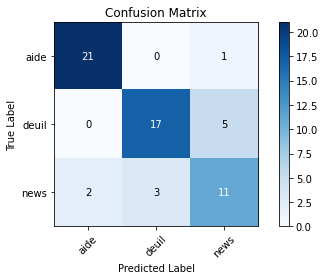

In [113]:
def visualize_matrice(cm):
    import numpy as np
    import matplotlib.pyplot as plt

    classes = ["aide", "deuil", "news"]
    cmap = plt.cm.Blues


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)


    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black")


    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()


    plt.savefig(f"confusion_matrix{cm}.png")
    
visualize_matrice(cm)


In [96]:

new_text = "#Turquie : après le séisme, l’aide taïwanaise au plus près des besoins."


new_text_features = vectorizer.transform([nettoyage(new_text)])


predicted_category = clf.predict(new_text_features)[0]

print("Predicted category:", predicted_category)

Predicted category: aide


---
### Modèle de SVC

In [114]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC


X_train, X_test, y_train, y_test = train_test_split(features, corpus_labels, test_size=0.2, random_state=42)


clf = SVC(kernel="linear")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


cm_svc = confusion_matrix(y_test, y_pred)
print("Matrice de confusion:")
print(cm_svc)

# calculer precision, recall, f-score
report = classification_report(y_test, y_pred)
print("Résultat des classifications:")
print(report)

# calculer kappa score
kappa = cohen_kappa_score(y_test, y_pred)
print("Kappa Score:", kappa)

Matrice de confusion:
[[19  0  3]
 [ 1 17  4]
 [ 2  2 12]]
Résultat des classifications:
              precision    recall  f1-score   support

        aide       0.86      0.86      0.86        22
       deuil       0.89      0.77      0.83        22
        news       0.63      0.75      0.69        16

    accuracy                           0.80        60
   macro avg       0.80      0.80      0.79        60
weighted avg       0.81      0.80      0.80        60

Kappa Score: 0.6992481203007519


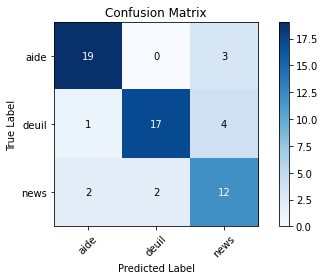

In [115]:
visualize_matrice(cm_svc)

---
### DecisionTree

In [116]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

X_train, X_test, y_train, y_test = train_test_split(features, corpus_labels, test_size=0.2, random_state=42)


clf = DecisionTreeClassifier(max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

cm_tree = confusion_matrix(y_test, y_pred)
print("Matrice de confusion:")
print(cm_tree)

# calculer precision, recall, f-score
report = classification_report(y_test, y_pred)
print("Résultat des classifications:")
print(report)

# calculer kappa score
kappa = cohen_kappa_score(y_test, y_pred)
print("Kappa Score:", kappa)

Matrice de confusion:
[[19  0  3]
 [ 5 15  2]
 [ 1  4 11]]
Résultat des classifications:
              precision    recall  f1-score   support

        aide       0.76      0.86      0.81        22
       deuil       0.79      0.68      0.73        22
        news       0.69      0.69      0.69        16

    accuracy                           0.75        60
   macro avg       0.75      0.74      0.74        60
weighted avg       0.75      0.75      0.75        60

Kappa Score: 0.6212121212121211


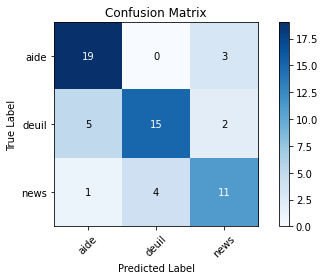

In [122]:
visualize_matrice(cm_tree)

In [86]:
from sklearn.tree import export_graphviz
import graphviz


clf = DecisionTreeClassifier(max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2)
clf.fit(X_train, y_train)

dot_data = export_graphviz(clf, out_file=None, feature_names=vectorizer.get_feature_names_out(), class_names=["aide", "deuil", "news"], filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph.render("decision_tree")

graph.view()


'decision_tree.pdf'

In [24]:
from sklearn.model_selection import GridSearchCV

# définir l'intervalle des paramètres
params = {
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None]
}
clf = DecisionTreeClassifier()
grid_search = GridSearchCV(clf, params, cv=5)
grid_search.fit(X_train, y_train)

# redonner les paramètres optimales avec des validations croisées 
print("Parametres Optimal:", grid_search.best_params_)
print("Score Optimal:", grid_search.best_score_)



Best Parameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Score: 0.7
Confusion Matrix:
[[16  0  6]
 [ 4 17  1]
 [ 2  5  9]]


---
### k-nearest-means

In [120]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


X_train, X_test, y_train, y_test = train_test_split(features, corpus_labels, test_size=0.2, random_state=42)


clf = KNeighborsClassifier(n_neighbors=14, weights = "distance")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

cm_k = confusion_matrix(y_test, y_pred)

print("Matrice de confusion:")
print(cm_k)

# calculer precision, recall, f-score
report = classification_report(y_test, y_pred)
print("Résultat des classifications:")
print(report)

# calculer kappa score
kappa = cohen_kappa_score(y_test, y_pred)
print("Kappa Score:", kappa)

Matrice de confusion:
[[20  1  1]
 [ 1 14  7]
 [ 2  3 11]]
Résultat des classifications:
              precision    recall  f1-score   support

        aide       0.87      0.91      0.89        22
       deuil       0.78      0.64      0.70        22
        news       0.58      0.69      0.63        16

    accuracy                           0.75        60
   macro avg       0.74      0.74      0.74        60
weighted avg       0.76      0.75      0.75        60

Kappa Score: 0.62406015037594


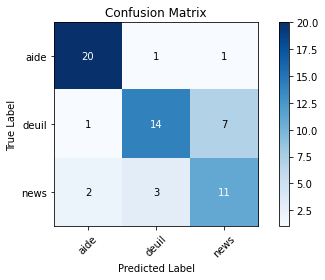

In [121]:
visualize_matrice(cm_k)

In [118]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV


# Définir les hyperparamètres à tester
k_values = list(range(1, 31))
weight_options = ['uniform', 'distance']
param_grid = dict(n_neighbors=k_values, weights=weight_options)

knn = KNeighborsClassifier()

# Créer une instance de GridSearchCV avec 5-fold cross-validation
grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

grid.fit(X_train, y_train)

print("Meilleurs hyperparamètres : ", grid.best_params_)
print("Meilleur score : ", grid.best_score_)

# Utiliser le modèle optimal pour prédire l'ensemble de test
y_pred = grid.predict(X_test)

# Calculer la précision du modèle sur l'ensemble de test
accuracy = np.mean(y_pred == y_test)
print("Précision sur l'ensemble de test : ", accuracy)


Meilleurs hyperparamètres :  {'n_neighbors': 14, 'weights': 'distance'}
Meilleur score :  0.8416666666666666
Précision sur l'ensemble de test :  0.75
